In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
train_files = ["Data/fem1.csv", "Data/fem2.csv", "Data/fem3.csv", "Data/fem4.csv", "Data/fem5.csv",
               "Data/piros1.csv", "Data/piros2.csv", "Data/piros3.csv", "Data/piros4.csv", "Data/piros5.csv", "Data/piros6.csv"]

dt = 0.01  # timestep

df_list = []
for filename in train_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    del df['NaN.2'], df['NaN.4'], df['NaN.5'], df['NaN.6'], df['NaN.7'], df['NaN.8'], df['NaN.9']
    df['RelErr'] = np.abs((df['NaN.11'] - df['NaN.10'])/df['NaN.11'])
    del df['NaN.10'], df['NaN.11']
    df.rename(columns = {'NaN':'Time', 'NaN.1': 'Psi', 'NaN.3': 'Mz'}, inplace = True)
    df['Ome'] = (df['Psi'].shift(periods=1) - df['Psi'])/dt
    df['Eps'] = (df['Ome'].shift(periods=1) - df['Ome'])/dt
    df_list.append(df)

df_train = pd.concat(df_list, axis=0, ignore_index=True)
df_train = df_train.dropna(axis=0)
df_train.head()

,Time,Psi,Mz,RelErr,Ome,Eps
2,0.02,0.024160,-2.529085,0.334639,-0.023429,0.493687
3,0.03,0.024397,-2.553327,0.345760,-0.023611,0.018186
4,0.04,0.024700,-2.577257,0.331862,-0.030371,0.675981
5,0.05,0.024964,-2.600805,0.330919,-0.026418,-0.395333
6,0.06,0.025242,-2.623746,0.323704,-0.027757,0.133984


In [3]:
df_normed = (df_train - df_train.mean())/df_train.std()
df_normed = df_normed.sample(frac=1)
del df_normed['Time']
df_normed.head()

,Psi,Mz,RelErr,Ome,Eps
18928,-0.515354,-0.725504,0.052492,-0.895895,0.609999
7135,0.937508,-1.303732,-0.802790,-0.901645,0.165284
8247,0.054005,-1.084277,-1.056180,-0.711859,0.142621
4199,-0.147316,0.759244,0.526460,0.645397,-0.434492
21465,1.019486,-1.484703,0.030854,-1.110968,0.830391


In [4]:
target = df_normed.pop('RelErr')
tf.convert_to_tensor(df_normed)

<tf.Tensor: shape=(21772, 4), dtype=float64, numpy=
array([[-0.51535378, -0.72550437, -0.89589479,  0.60999924],
       [ 0.93750829, -1.30373244, -0.90164495,  0.16528413],
       [ 0.05400491, -1.08427686, -0.71185852,  0.14262054],
       ...,
       [-0.71138598,  1.45337219,  0.98471382,  0.3649781 ],
       [-1.15823667,  0.99975082,  0.16544808,  1.23775752],
       [ 0.16036486, -1.16991023, -0.54472016,  0.21639283]])>

In [5]:
def get_basic_model(n_hidden=2, n_nodes=64, reg_lambda=0.001):
    regularizer = tf.keras.regularizers.l2(reg_lambda)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(n_nodes, input_shape=(4,), activation='tanh',
                                    kernel_regularizer=regularizer))
    for i in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_nodes, activation='tanh', kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_squared_error',
                  metrics = [tf.keras.metrics.RootMeanSquaredError()]
                  )
    return model

In [20]:
model = get_basic_model(n_hidden=2, n_nodes=64 , reg_lambda=0.001)

EPOCHS = 5000
BATCH_SIZE = 512
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = EPOCHS, mode = "min",
                                                 restore_best_weights = True)

history = model.fit(
    df_normed, target,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    verbose = 1,
    shuffle = False,
    callbacks=[early_stopper]
)

Epoch 1/5000
35/35 [==============================] - 2s 9ms/step - loss: 1.1664 - root_mean_squared_error: 1.0156 - val_loss: 0.9942 - val_root_mean_squared_error: 0.9289
Epoch 2/5000
35/35 [==============================] - 0s 5ms/step - loss: 1.1178 - root_mean_squared_error: 0.9946 - val_loss: 0.9476 - val_root_mean_squared_error: 0.9066
Epoch 3/5000
35/35 [==============================] - 0s 5ms/step - loss: 1.0536 - root_mean_squared_error: 0.9643 - val_loss: 0.8823 - val_root_mean_squared_error: 0.8721
Epoch 4/5000
35/35 [==============================] - 0s 5ms/step - loss: 1.0008 - root_mean_squared_error: 0.9384 - val_loss: 0.8479 - val_root_mean_squared_error: 0.8543
Epoch 5/5000
35/35 [==============================] - 0s 5ms/step - loss: 0.9747 - root_mean_squared_error: 0.9265 - val_loss: 0.8304 - val_root_mean_squared_error: 0.8462
Epoch 6/5000
35/35 [==============================] - 0s 5ms/step - loss: 0.9597 - root_mean_squared_error: 0.9203 - val_loss: 0.8180 - val_

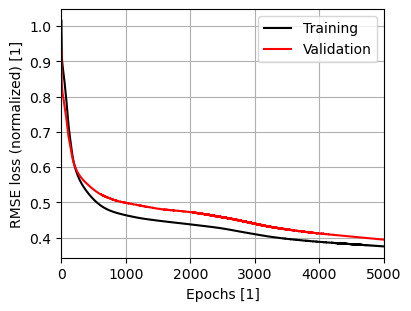

In [21]:
plt.figure(figsize=(4,3), layout="constrained")
plt.plot(history.history['root_mean_squared_error'], 'k')
plt.plot(history.history['val_root_mean_squared_error'], 'r')
plt.ylabel('RMSE loss (normalized) [1]')
plt.xlabel('Epochs [1]')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.xlim((0, EPOCHS))
plt.grid()
#plt.savefig("errors.pdf", facecolor="white")
plt.show()

In [ ]:
test_files = ["Data/fem6.csv", "Data/piros7.csv"]
# "Data/fem6.csv", "Data/piros7.csv"

dt = 0.01  # timestep

df_list = []
for filename in test_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    del df['NaN.2'], df['NaN.4'], df['NaN.5'], df['NaN.6'], df['NaN.7'], df['NaN.8'], df['NaN.9']
    df['RelErr'] = np.abs((df['NaN.11'] - df['NaN.10'])/df['NaN.11'])
    del df['NaN.10'], df['NaN.11']
    df.rename(columns = {'NaN':'Time', 'NaN.1': 'Psi', 'NaN.3': 'Mz'}, inplace = True)
    df['Ome'] = (df['Psi'].shift(periods=1) - df['Psi'])/dt
    df['Eps'] = (df['Ome'].shift(periods=1) - df['Ome'])/dt
    df_list.append(df)

df_test = pd.concat(df_list, axis=0, ignore_index=True)
df_test = df_test.dropna(axis=0)
df_test.head()

In [16]:
df_test_normed = (df_test - df_train.mean())/df_train.std()
del df_test_normed['Time']
df_test_normed.head()

,Psi,Mz,RelErr,Ome,Eps
2,-0.037009,-0.770369,-1.051562,-0.680329,-0.241735
3,-0.033419,-0.787112,-1.036512,-0.753541,1.641886
4,-0.029803,-0.804458,-1.006515,-0.758679,0.123773
5,-0.026051,-0.822263,-0.977518,-0.786134,0.621447
6,-0.021954,-0.840217,-0.976702,-0.855996,1.567189


In [17]:
test_target = df_test_normed.pop('RelErr').to_numpy()
tf.convert_to_tensor(df_test_normed)

test_results = model.predict(df_test_normed)

144/144 [==============================] - 0s 1ms/step


In [18]:
# Back scaling
test_target = test_target*df_train['RelErr'].std() + df_train['RelErr'].mean()
test_results = test_results*df_train['RelErr'].std() + df_train['RelErr'].mean()

RMSE = np.sqrt(np.mean((test_target - test_results)**2))
RMSE

0.3083609013387863

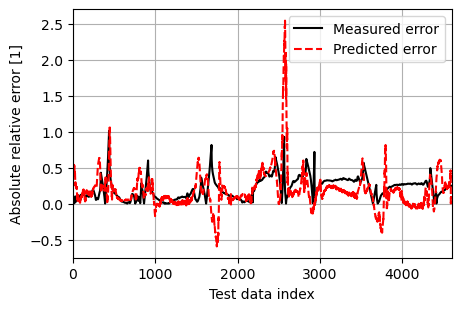

In [19]:
plt.figure(figsize=(4.5,3), layout="constrained")
plt.plot(test_target, 'k')
plt.plot(test_results, '--r')
plt.xlabel("Test data index")
plt.ylabel("Absolute relative error [1]")
plt.legend(("Measured error", "Predicted error"))
plt.xlim((0, test_target.shape[0]))
plt.grid()
#plt.savefig('test_results.pdf', facecolor="white")
plt.show()

In [79]:
#np.savetxt("piros7_errorPred.csv", test_results, delimiter=",")